# calc w'b' ~ Ri with scaling

parameterization of Killworth
$$\frac{\overline{w'b'}}{H^2f^3} = C_s \frac{1}{\sqrt{1+Ri}} \mu_s(z) \alpha^2$$

$$\mu_s(z) = -4 \frac{z}{H} (\frac{z}{H} + 1)$$

H is mixed layer depth
C_s is 1


In [1]:
%%capture
import sys
import glob, os
#os.chdir('/home/m/m300878/submesoscaletelescope/notebooks/may22/')
#sys.path.insert(1, '../')
#from icon_smt_levels import dzw, dzt, depthc, depthi
#sys.path.insert(1, '/home/m/m300878/submesoscaletelescope/run_batch_job/model_evaluation/')
#from eval_funcs import *
#import eval_funcs as eva

#os.chdir('/home/m/m300878/')
#"/work/mh0033/m300878/pyicon/")
import pyicon as pyic

#sys.path.append("/home/m/m300878/submesoscaletelescope/")
#from eval_funcs import *
#from smt_modules import all_funcs as eva
import smt_modules.all_funcs as eva
from smt_modules.icon_smt_levels import dzw, dzt, depthc, depthi

import pandas as pd
import netCDF4 as nc
import xarray as xr    
import numpy as np
import datetime          #https://docs.python.org/3/library/datetime.html

import matplotlib.pyplot as plt
from scipy.interpolate import interp1d  #for converting cell to grid-centered coordinates
import cartopy.crs as ccrs
ccrs_proj = ccrs.PlateCarree()
#sys.path.insert(1, '/home/m/m300878/miniconda3/envs/pyicon_py39/')
#sys.path.insert(1, '/home/m/m300878/miniconda3/envs/pyicon_py39/bin/python')
# sys.path.insert(1, '/work/mh0033/m300878/pyicon/pyicon')

import gsw

from scipy import stats    #Used for 2D binned statistics
from importlib import reload

In [28]:
#Reload modules:
reload(eva)

Load my smt functions


<module 'smt_modules.all_funcs' from '/home/m/m300878/submesoscaletelescope/smt_modules/all_funcs.py'>

In [1]:
print(sys.path)

['/home/m/m300878/submesoscaletelescope/notebooks/july22', '/work/mh0033/m300878/pyicon', '/home/m/m300878/submesoscaletelescope', '/home/m/m300878/miniconda3/envs/pyicon_py39/lib/python39.zip', '/home/m/m300878/miniconda3/envs/pyicon_py39/lib/python3.9', '/home/m/m300878/miniconda3/envs/pyicon_py39/lib/python3.9/lib-dynload', '', '/home/m/m300878/miniconda3/envs/pyicon_py39/lib/python3.9/site-packages']


### select region

In [10]:
fpath_ckdtree = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.npz'
fpath_ckdtree = '/work/mh0033/m300602/icon/grids/smt/ckdtree/rectgrids/smt_res0.02_180W-180E_90S-90N.nc'

lon_reg_large = [-72.5, -55]
lat_reg_large = [32, 42]
asp_large = (lat_reg_large[1]-lat_reg_large[0])/(lon_reg_large[1]-lon_reg_large[0])

lon_reg = [-65, -60]
lat_reg = [38.75, 41.25]
#lon_reg = [-65, -60]
#lat_reg = [33, 35.5]
calcname = 'small_33_34'


lon_reg = lon_reg_large
lat_reg = lat_reg_large

#on_reg = [-65, -60]
#lat_reg = [32, 34.5]
asp = (lat_reg[1]-lat_reg[0])/(lon_reg[1]-lon_reg[0])

idepth = 5
itime = 42
tt=1

##### funcs

def calc_mld_montegut(rho_mean, depthc):
    """ 
    applies Montegut 2004 Threshold Method
    if salinity can be negelcted it is equivalent to dT = 0.2 
    """

    #rho_surf_mean = rho_mean.isel(depthc=2) #should be 10m
    #diff = xr.ufuncs.sqrt((rho_surf_mean - rho_mean)**2)
    
    #d = diff.where(diff<=0.03)
    #dd = np.sum(~np.isnan(d), axis=2)
    #return(depthc[dd-1], ~np.isnan(d))   
    
    rho_mean = data_rho_mean
    rho_surf_mean = rho_mean.isel(depthc=2) #should be 10m
    diff = xr.ufuncs.sqrt((rho_surf_mean - rho_mean)**2)
    
    d = diff.where(diff<=0.03)
    dd = np.sum(~np.isnan(d), axis=rho_mean.ndim-1)

    return(dd, ~np.isnan(d))   

In [3]:
def scatter_data(x,y):
    plt.figure()
    plt.scatter(x,y)
    #plt.xlim(-1, 10)
    #plt.ylim(-5,5)

In [4]:
def calc_log10(x_data, y_data):
    #x_data = np.reshape(rhs.data, laty*lonx)
    #y_data = np.reshape(lhs.data, laty*lonx)
    #x_data = np.reshape(ri_mld_mean.data, laty*lonx)

    #scatter_data(x_data,y_data)
    #y_data = np.reshape(wb_mld_mean.data, laty*lonx)
    mask = ~np.isnan(x_data) & ~np.isnan(y_data) #remove nans from original data
    x_data = x_data[mask]
    y_data = y_data[mask]
    #scatter_data(x_data,y_data) # nothing happens

    mask = np.ma.masked_where((x_data >= 0), x_data) # remove zeros and negative numbers from xdata
    x_data = x_data[mask.mask]
    y_data = y_data[mask.mask]
    #scatter_data(x_data,y_data)

    logx = np.log10(np.abs(x_data)) #not nessecary
    logy = np.log10(np.abs(y_data))
    #scatter_data(logx,logy)
    mask = ~np.isnan(logx) & ~np.isnan(logy) & ~np.isinf(logy) #remove inf numbers and nans again after taking log
    logx = logx[mask]
    logy = logy[mask]
    #x_data = x_data[mask]
    #y_data = y_data[mask]
    return(logx,logy)

In [5]:
#time_averaged = '_d_mean'
time_averaged = ''

## calc H - MLD

In [6]:
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/t{time_averaged}.nc'
t_mean = xr.open_dataset(path_data, chunks=dict(depthc=1))
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/s{time_averaged}.nc'
s_mean = xr.open_dataset(path_data, chunks=dict(depthc=1))

In [7]:
%%time
#1d 2d
#data_t_mean  = pyic.interp_to_rectgrid_xr(t_mean.isel(time=tt), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
#data_s_mean  = pyic.interp_to_rectgrid_xr(s_mean.isel(time=tt), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
#1week
data_t_mean  = pyic.interp_to_rectgrid_xr(t_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_s_mean  = pyic.interp_to_rectgrid_xr(s_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)

CPU times: user 1.54 s, sys: 37.4 s, total: 38.9 s
Wall time: 56.8 s


#### visual

In [ ]:
data_t_mean.T001_sp.isel(depthc=3, time=1).plot()

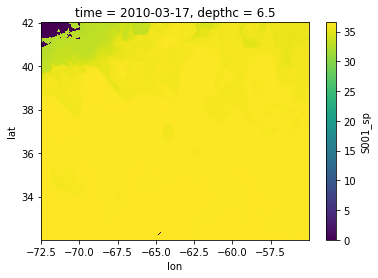

In [ ]:
data_s_mean.isel(depthc=1).S001_sp.plot()

#### calc rho

In [11]:
rho_mean = gsw.rho(data_s_mean.S001_sp, data_t_mean.T001_sp, depthc[2])
data_rho_mean = rho_mean
#data_rho_mean      = pyic.interp_to_rectgrid_xr(rho_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)

#### mld + mask

In [12]:
mld, mld_mask, mldx = eva.calc_mld_montegut_xr(data_rho_mean, depthc)
#mldx =  xr.DataArray(data=mld, dims=["lat", "lon"], coords=dict(lon=(["lon"], mld_mask.lon.data), lat=(["lat"], mld_mask.lat.data)))

def func(a):
    return(depthc[a-1])


mldx = xr.apply_ufunc(func, mld)

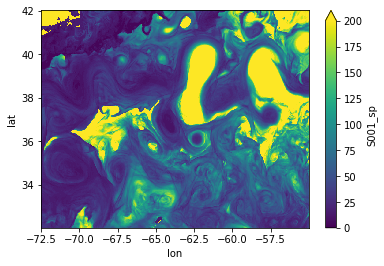

In [12]:
mldx.plot(vmin=0, vmax=200)

## calc f

In [13]:
#lat = data_rho_mean.lat
#f=2*2*np.pi/86400*np.sin(lat*np.pi/180.)
f = eva.calc_coriolis_parameter(data_rho_mean.lat)

## calc Ri

In [14]:
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/bx{time_averaged}.nc'
dbdx_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/by{time_averaged}.nc'
dbdy_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/n2{time_averaged}.nc'
n_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))

In [15]:
%%time
#1d2d
#data_dbdx_mean   = pyic.interp_to_rectgrid_xr(dbdx_mean.dbdx.isel(time=tt), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
#data_dbdy_mean   = pyic.interp_to_rectgrid_xr(dbdy_mean.dbdy.isel(time=tt), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
#data_n2_mean     = pyic.interp_to_rectgrid_xr(n_mean.N2.isel(time=tt), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)

#1week
data_dbdx_mean   = pyic.interp_to_rectgrid_xr(dbdx_mean.dbdx, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_dbdy_mean   = pyic.interp_to_rectgrid_xr(dbdy_mean.dbdy, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_n2_mean     = pyic.interp_to_rectgrid_xr(n_mean.N2, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)

CPU times: user 2.38 s, sys: 1min 3s, total: 1min 5s
Wall time: 1min 34s


In [16]:
# data_M2_mean = np.sqrt(np.power(data_dbdx_mean,2) + np.power(data_dbdy_mean,2))
data_M2_mean = np.abs(data_dbdx_mean) + np.abs(data_dbdy_mean)
#data_M2_mean = np.abs(data_dbdx_mean) #+ np.abs(data_dbdy_mean)
#data_M2_mean = np.abs(data_dbdy_mean)

In [17]:
lat_mean = int((data_n2_mean.lat[-1] - data_n2_mean.lat[0]) /2 + data_n2_mean.lat[0])

def calc_richardsonnumber(lat, N2, M2):
    """calculates Richardssonumber with respect to latitude"""

    f=2*2*np.pi/86400*np.sin(lat*np.pi/180.)
    f2 = f**2
    M4 = xr.ufuncs.square(M2)
    
    return N2 * f2  / M4 

In [57]:
ri_mean = eva.calc_richardsonnumber(lat_mean, data_n2_mean, data_M2_mean)

### average over MLD

In [19]:
#mld_mask = mld_mask.transpose('time','depthc', 'lat', 'lon')
mld_mask = mld_mask.transpose('depthc', 'lat', 'lon')
mld_mask = mld_mask.rename(depthc='depthi') #small error

In [58]:

ri_mean_select = ri_mean.sel(depthi=slice(depthi[0], depthi[111])) #ri_mean[:112]
ri_mld = ri_mean_select * mld_mask.data
ri_mld = ri_mld.where(ri_mld != 0)
ri_mld_mean = ri_mld.mean(dim='depthi', skipna=True)


## get wb prime

In [21]:
path_data = f'/work/mh0033/m300878/parameterization/time_averages/one_week_march/wb{time_averaged}_prime.nc'
wb_prime_mean = xr.open_dataset(path_data, chunks=dict(depthi=1))
wb_prime_mean = wb_prime_mean.rename(__xarray_dataarray_variable__='wb_prime_mean')

In [22]:
%%time
#data_wb_prime_mean  = pyic.interp_to_rectgrid_xr(wb_prime_mean.wb_prime_mean.isel(time=tt), fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg)
data_wb_prime_mean  = pyic.interp_to_rectgrid_xr(wb_prime_mean.wb_prime_mean, fpath_ckdtree, lon_reg=lon_reg, lat_reg=lat_reg) #week

CPU times: user 799 ms, sys: 19.1 s, total: 19.9 s
Wall time: 26.1 s


In [23]:
#wb_mld = data_wb_prime_mean[:112] * mld_mask.data
wb_mld = data_wb_prime_mean.sel(depthi=slice(depthi[0], depthi[111])) * mld_mask.data
wb_mld = wb_mld.where(wb_mld != 0) #neglect zeros in average
wb_mld_mean = wb_mld.mean(dim='depthi', skipna=True)

In [59]:
#M2_mld = data_M2_mean[:112] * mld_mask.data
M2_mld = data_M2_mean.sel(depthi=slice(depthi[0], depthi[111])) * mld_mask.data
M2_mld = M2_mld.where(M2_mld !=0)
M2_mld_mean = M2_mld.mean(dim='depthi', skipna=True)

### unscaled

In [ ]:
laty, lonx, = ri_mld_mean.shape
logx, logy = calc_log10(np.reshape(ri_mld_mean.data, laty*lonx), np.reshape(wb_mld_mean.data, laty*lonx))

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(logx, logy , 'ro', markersize=1)

powerlaw = lambda x, amp, index: amp * (x**index)
res = stats.linregress(logx, logy)
plt.plot(logx, res.intercept + res.slope*logx, 'b', label=f'slope={res.slope:.2f}')


#plt.xlim(0,6)
#plt.ylim(-12,-6)
ax.set_xlabel(r'$log_{10} \overline{Ri}$', fontsize=30)
ax.set_ylabel(r'$log_{10} |\overline{w^{\prime} b^{\prime}}| $', fontsize=30)
res
plt.legend()

plt.savefig(f'../images/eval_ri/wb_ri_vert_mean_{calcname}.png', dpi=150, format='png', bbox_inches='tight')

res

LinregressResult(slope=-0.13893505354862887, intercept=-7.411050481959013, rvalue=-0.21202230193156002, pvalue=0.0, stderr=0.0036226922585509687, intercept_stderr=0.009042534674917672)

## scaling

#### calcute alpha using mld averaged M2

#### calculate lhs and rhs (killworth), like Nils

In [25]:
alpha = M2_mld_mean / np.power(f,2)
lhs = wb_mld_mean / np.power(mld,2) / np.power(f,3) / np.power(alpha,2)
lhs_without_alpha = wb_mld_mean / np.power(mld,2) / np.power(f,3)
rhs = 1 / np.sqrt(1 + ri_mld_mean) #* np.power(alpha,2) #* mu * np.power(alpha,2)

### visual lhs rhs alpha etc

In [152]:
lhs.mean()

<xarray.DataArray ()>
array(11.72469699)

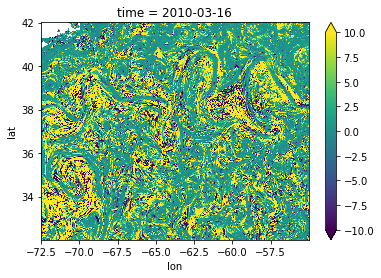

In [154]:
#with alpha
lhs.isel(time=0).plot(vmin=-10, vmax=10)

In [158]:
ri_mld_mean.shape

(3, 500, 875)

In [159]:
dt, laty, lonx, = ri_mld_mean.shape
logx, logy = calc_log10(np.reshape(ri_mld_mean.isel(time=tt).data, laty*lonx), np.reshape(lhs_without_alpha.isel(time=tt).data, laty*lonx))

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(logx, logy , 'ro', markersize=0.5)

powerlaw = lambda x, amp, index: amp * (x**index)
res = stats.linregress(logx, logy)
plt.plot(logx, res.intercept + res.slope*logx, 'b', label=f'slope={res.slope:.2f}')

x1 = np.linspace(-1,6,100)
y1 = -0.5*x1 + 1
plt.plot(x1,y1, label='slope ALS, NLS: -0.5', color='black')
#plt.xlim(0,6)
#plt.ylim(-12,-6)
ax.set_xlabel(r'$log_{10} \overline{Ri}$', fontsize=30)
ax.set_ylabel(r'$log_{10} |\overline{w^{\prime} b^{\prime}}|/(H^2 f^3) $', fontsize=30)
res
plt.legend()

plt.savefig(f'../images/eval_ri/wb_ri_vert_mean_scaled_{calcname}.png', dpi=150, format='png', bbox_inches='tight')

res

LinregressResult(slope=-0.23464861202337225, intercept=1.4918664327247213, rvalue=-0.2923583444801692, pvalue=0.0, stderr=0.004341997342349478, intercept_stderr=0.010837978697726895)

In [ ]:
logx, logy = calc_log10(np.reshape(rhs.data, laty*lonx), np.reshape(lhs.data, laty*lonx))

LinregressResult(slope=-1.1180471034910209, intercept=-1.188961521428907, rvalue=-0.6130780860033698, pvalue=0.0, stderr=0.008150280474545595, intercept_stderr=0.01018715061795759)

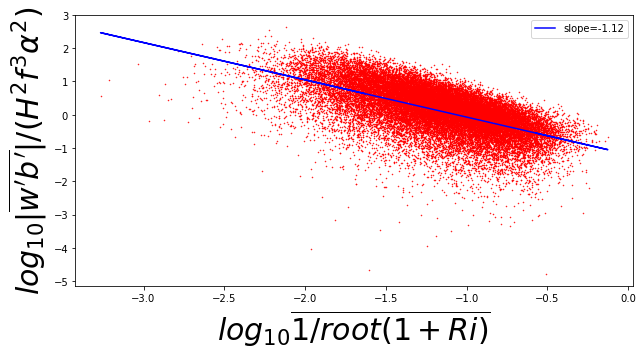

In [ ]:

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(logx, logy , 'ro', markersize=0.5)

powerlaw = lambda x, amp, index: amp * (x**index)
res = stats.linregress(logx, logy)
plt.plot(logx, res.intercept + res.slope*logx, 'b', label=f'slope={res.slope:.2f}')

# x1 = np.linspace(-1,6,100)
# y1 = -0.5*x1 + 1
# plt.plot(x1,y1, label='slope ALS, NLS: -0.5', color='black')
#plt.xlim(0,6)
#plt.ylim(-12,-6)
ax.set_xlabel(r'$log_{10} \overline{1 / root(1+Ri)} $', fontsize=30) #
ax.set_ylabel(r'$log_{10} |\overline{w^{\prime} b^{\prime}}|/(H^2 f^3 \alpha^2) $', fontsize=30)
res
plt.legend()

plt.savefig(f'../images/eval_ri/wb_ri_vert_mean_scaled_lhs_rhs_{calcname}.png', dpi=150, format='png', bbox_inches='tight')

res

### calc ri w'b' log

In [26]:
tt=1
laty, lonx = ri_mld_mean.shape
#logx, logy = calc_log10(np.reshape(ri_mld_mean.isel(time=tt).data, laty*lonx), np.reshape(lhs.isel(time=tt).data, laty*lonx))
logx, logy = calc_log10(np.reshape(ri_mld_mean.data, laty*lonx), np.reshape(lhs.data, laty*lonx))

In [27]:
#south
ri_mld_mean_s = ri_mld_mean.sel(lat=slice(32, 34,5)).sel(lon=slice(-65,-60))
lhs_s = lhs.sel(lat=slice(32, 34,5)).sel(lon=slice(-65,-60))
laty, lonx = ri_mld_mean_s.shape

logx, logy = calc_log10(np.reshape(ri_mld_mean_s.data, laty*lonx), np.reshape(lhs_s.data, laty*lonx))

In [28]:
#north
#lon_reg = [-65, -60]
#lat_reg = [38.75, 41.25]
ri_mld_mean_n = ri_mld_mean.sel(lat=slice(38.75, 41.25)).sel(lon=slice(-65,-60))
lhs_n         =         lhs.sel(lat=slice(38.75, 41.25)).sel(lon=slice(-65,-60))
laty, lonx = ri_mld_mean_n.shape

logx, logy = calc_log10(np.reshape(ri_mld_mean_n.data, laty*lonx), np.reshape(lhs_n.data, laty*lonx))

LinregressResult(slope=0.5170360950954491, intercept=-0.2681902811482275, rvalue=0.5678994267168562, pvalue=0.0, stderr=0.0042622351095653686, intercept_stderr=0.008135757335067897)

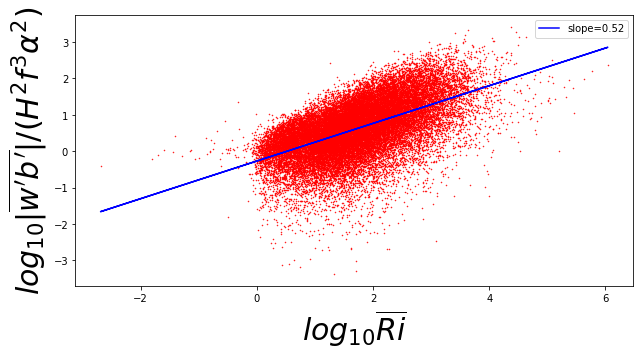

In [29]:

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(logx, logy , 'ro', markersize=0.5)

powerlaw = lambda x, amp, index: amp * (x**index)
res = stats.linregress(logx, logy)
plt.plot(logx, res.intercept + res.slope*logx, 'b', label=f'slope={res.slope:.2f}')

# x1 = np.linspace(-1,6,100)
# y1 = -0.5*x1 + 1
# plt.plot(x1,y1, label='slope ALS, NLS: -0.5', color='black')
#plt.xlim(0,6)
#plt.ylim(-12,-6)
ax.set_xlabel(r'$log_{10} \overline{Ri}$', fontsize=30)
ax.set_ylabel(r'$log_{10} |\overline{w^{\prime} b^{\prime}}|/(H^2 f^3 \alpha^2) $', fontsize=30)

plt.legend()

plt.savefig(f'../images/eval_ri/wb_ri_vert_mean_scaled_alpha_north.png', dpi=150, format='png', bbox_inches='tight')

res

### a glance on alpha dependency

In [ ]:
#x_data = np.reshape(rhs.data, laty*lonx)
y_data = np.reshape(lhs.data, laty*lonx)
x_data = np.reshape(alpha.data, laty*lonx)
#y_data = np.reshape(wb_mld_mean.data, laty*lonx)
mask = ~np.isnan(x_data) & ~np.isnan(y_data) #remove nans from original data
x_data = x_data[mask]
y_data = y_data[mask]

mask = np.ma.masked_where((x_data >= 0), x_data) # remove zeros and negative numbers from xdata
x_data = x_data[mask.mask]
y_data = y_data[mask.mask]

logx = np.log10(np.abs(x_data)) #not nessecary
logy = np.log10(np.abs(y_data))
mask = ~np.isnan(logx) & ~np.isnan(logy) & ~np.isinf(logy) #remove inf numbers and nans again after taking log
logx = logx[mask]
logy = logy[mask]
x_data = x_data[mask]
y_data = y_data[mask]

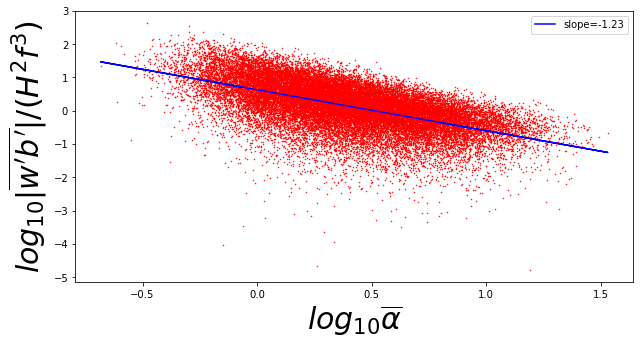

In [ ]:
fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(logx, logy , 'ro', markersize=0.5)

powerlaw = lambda x, amp, index: amp * (x**index)
res = stats.linregress(logx, logy)
plt.plot(logx, res.intercept + res.slope*logx, 'b', label=f'slope={res.slope:.2f}')

# x1 = np.linspace(-1,6,100)
# y1 = -0.5*x1 + 1
# plt.plot(x1,y1, label='slope ALS, NLS: -0.5', color='black')
#plt.xlim(0,6)
#plt.ylim(-12,-6)
ax.set_xlabel(r'$log_{10} \overline{\alpha}$', fontsize=30)
ax.set_ylabel(r'$log_{10} |\overline{w^{\prime} b^{\prime}}|/(H^2 f^3) $', fontsize=30)
res
plt.legend()

# Evaluate one front vertical slice

## calc

In [54]:
#change M2
data_M2_mean = np.abs(data_dbdx_mean) + np.abs(data_dbdy_mean)

In [55]:
n2=data_n2_mean.sel(lat=slice(32.5,33.5)).sel(lon=-61.25, method='nearest')


In [56]:
m2=data_M2_mean.sel(lat=slice(32.5,33.5)).sel(lon=-61.25, method='nearest')
rho_slice = data_rho_mean.sel(lat=slice(32.5,33.5)).sel(lon=-61.25, method='nearest')
wb_prime_slice = data_wb_prime_mean.sel(lat=slice(32.5,33.5)).sel(lon=-61.25, method='nearest')
m2_slice = data_M2_mean.sel(lat=slice(32.5,33.5)).sel(lon=-61.25, method='nearest')
psi =  - wb_prime_slice / m2_slice # vorzeichen! ToDO

In [32]:
tt=5

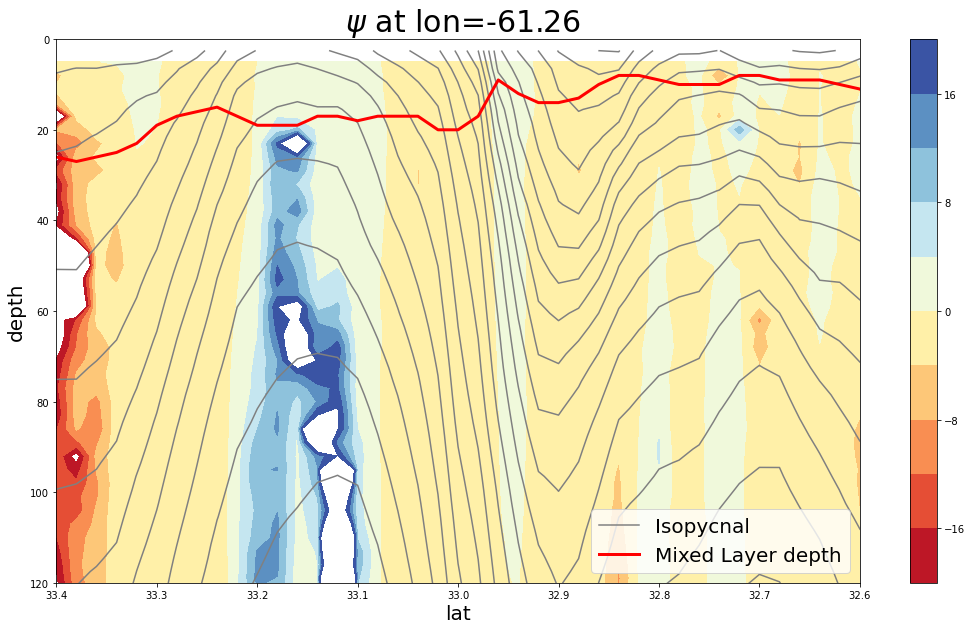

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(18,10))
clim = 100
levels= np.linspace(-20,20,11)
#cf = ax.contourf(psi.lat, psi.depthi, psi.isel(time=tt).data, levels, cmap='RdYlBu')
cf = ax.contourf(psi.lat, psi.depthi, psi.data, levels, cmap='RdYlBu')

plt.ylim(120,0)
cb = fig.colorbar(cf, ax=ax)
plt.xlim(33.4,32.6)

levels = np.linspace(1026,1027,100)
#plt.contour(rho_slice.lat, rho_slice.depthc, rho_slice.isel(time=tt).data, levels, colors='gray', label='rho contour')
plt.contour(rho_slice.lat, rho_slice.depthc, rho_slice.data, levels, colors='gray', label='rho contour')

plt.plot([], [], 'grey', label="Isopycnal")

#plt.plot(data_M2_mean.lat, mld.sel(lon=-61.26, method='nearest').isel(time=tt),'r', linewidth=3, label='Mixed Layer depth')
plt.plot(data_M2_mean.lat, mld.sel(lon=-61.26, method='nearest'),'r', linewidth=3, label='Mixed Layer depth')


plt.legend(loc='lower right', fontsize=20)
plt.title(f' $\psi$ at lon={m2.lon.data:.2f}', fontsize=30)
plt.xlabel('lat', size=20)
plt.ylabel('depth', size=20)

#plt.savefig(f'../images/eval_ri/psid_{tt}.png', dpi=150, format='png', bbox_inches='tight')
plt.savefig(f'../images/eval_ri/psid_week.png', dpi=150, format='png', bbox_inches='tight')




## slices

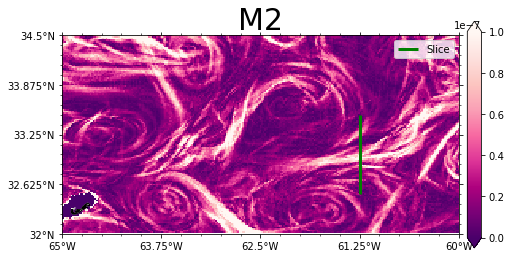

In [60]:
hca, hcb = pyic.arrange_axes(1, 1, plot_cb=True, asp=asp_large, fig_size_fac=2, projection=ccrs_proj, axlab_kw=None)
ii=-1
lon_reg1 = data_M2_mean.lon
lat_reg1 = data_M2_mean.lat
lon_regs = [-65, -60]
lat_regs = [32, 34.5]

ii+=1; ax=hca[ii]; cax=hcb[ii]
clim= 0, 1e-7
pyic.shade(lon_reg1, lat_reg1, data_M2_mean.isel(depthi=17), ax=ax, cax=cax,  transform=ccrs_proj, rasterized=False, clim=clim, cmap='RdPu_r')
ax.vlines(-61.25, 32.5, 33.5, color='g', linewidth=3, label='Slice')
ax.legend()
ax.set_title('M2', fontsize=30)

for ax in hca:
    pyic.plot_settings(ax, xlim=lon_regs, ylim=lat_regs) # , xlim=lon_region_large, ylim=lat_region_large

#plt.savefig(f'../images/eval_ri/m2_front_select1d.png', dpi=150, format='png', bbox_inches='tight')


### streamfunction

(120.0, 0.0)

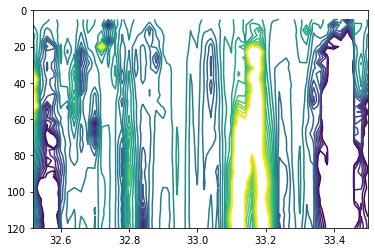

In [89]:
levels = np.linspace(-10,10,20)
plt.contour(psi.lat,psi.depthi, psi.data, levels)
plt.ylim(120,0)

(150.0, 0.0)

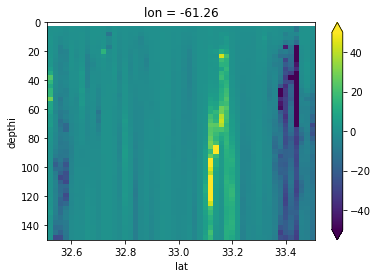

In [90]:
psi.plot(vmin=-50, vmax=50)
plt.ylim(150,0)

## plot Front

In [215]:
tt=5

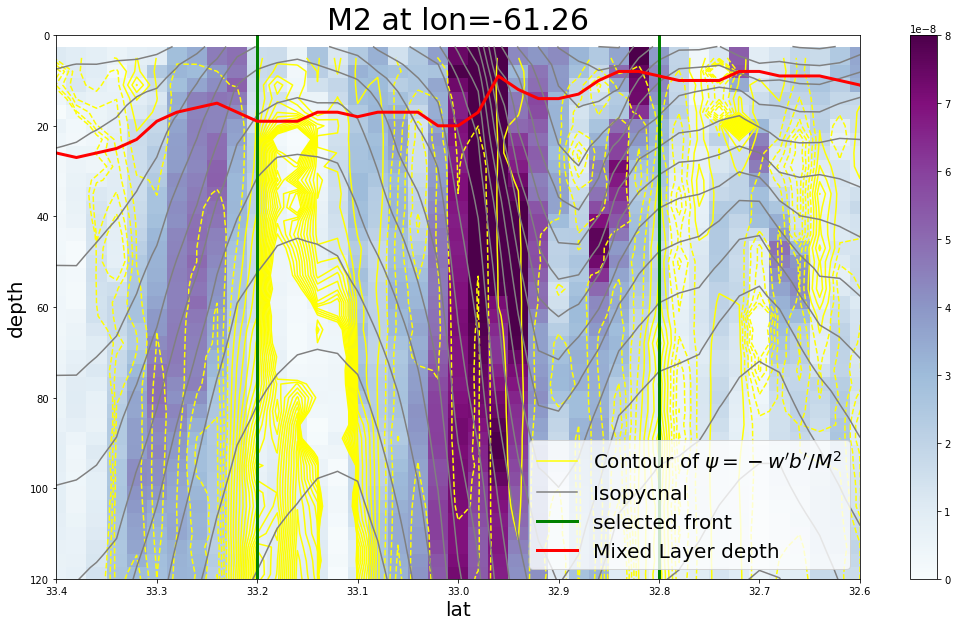

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(18,10))
#cf = ax.pcolormesh(m2.lat, m2.depthi, m2.isel(time=tt), vmin=0, vmax=8e-8,  cmap='BuPu')
cf = ax.pcolormesh(m2.lat, m2.depthi, m2, vmin=0, vmax=8e-8,  cmap='BuPu')


levels = np.linspace(-5,15,20)
#plt.contour(psi.lat,psi.depthi, psi.isel(time=tt).data, levels, colors='yellow')
plt.contour(psi.lat,psi.depthi, psi.data, levels, colors='yellow')

plt.plot([], [], 'yellow', label="Contour of $ \psi = - w'b' / M^2$")

levels = np.linspace(1026,1027,100)
#plt.contour(rho_slice.lat, rho_slice.depthc, rho_slice.isel(time=tt).data, levels, colors='gray', label='rho contour')
plt.contour(rho_slice.lat, rho_slice.depthc, rho_slice.data, levels, colors='gray', label='rho contour')

plt.plot([], [], 'grey', label="Isopycnal")
#plt.quiver(xi, yi, uCi, vCi)
#plt.ylim(120,0)
plt.axvline(x=33.2, color='g', linestyle='-', linewidth=3, label='selected front')
plt.axvline(x=32.8, color='g', linestyle='-', linewidth=3)

# plt.plot(data_M2_mean.lat, mld.sel(lon=-61.26, method='nearest').isel(time=tt),'r', linewidth=3, label='Mixed Layer depth')
plt.plot(data_M2_mean.lat, mld.sel(lon=-61.26, method='nearest'),'r', linewidth=3, label='Mixed Layer depth')


plt.gca().invert_yaxis()
cb = fig.colorbar(cf, ax=ax)
plt.xlim(33.4,32.6)
plt.ylim(120,0)
plt.title(f'M2 at lon={m2.lon.data:.2f}', fontsize=30)
plt.xlabel('lat', size=20)
plt.ylabel('depth', size=20)
plt.legend(loc='lower right', fontsize=20)


#plt.savefig(f'../images/eval_ri/m2_front2_d_{tt}.png', dpi=150, format='png', bbox_inches='tight')
plt.savefig(f'../images/eval_ri/m2_front_week.png', dpi=150, format='png', bbox_inches='tight')




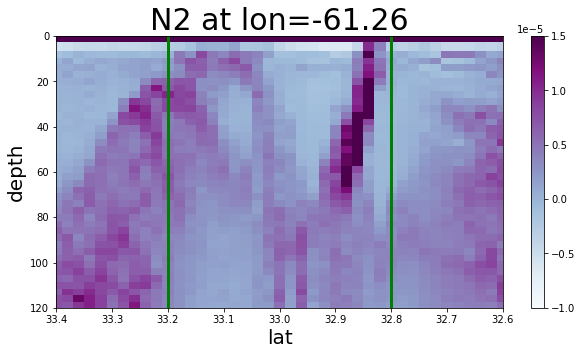

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
cf = ax.pcolormesh(n2.lat, n2.depthi, n2,  vmin=-1.e-5, vmax=1.5e-5,  cmap='BuPu')

plt.axvline(x=33.2, color='g', linestyle='-', linewidth=3, label='selected front')
plt.axvline(x=32.8, color='g', linestyle='-', linewidth=3)

plt.gca().invert_yaxis()
cb = fig.colorbar(cf, ax=ax)
plt.xlim(33.4,32.6)
plt.ylim(120,0)
plt.title(f'N2 at lon={m2.lon.data:.2f}', fontsize=30)
plt.xlabel('lat', size=20)
plt.ylabel('depth', size=20)
#plt.legend(loc='lower right', fontsize=20)


plt.savefig(f'../images/eval_ri/n2_front_1d.png', dpi=150, format='png', bbox_inches='tight')



### selection of front
lat = 33.2, 32,8
depth is mld

In [61]:
m2_fslect = M2_mld.sel(lon=-61.25, method='nearest').sel( lat=slice(32.8,33.2)).mean(dim='depthi', skipna=True)
m2_fslect

<xarray.DataArray (lat: 20)>
array([7.3158340e-08, 4.3849404e-08, 3.3400468e-08, 2.1126523e-08,
       3.7205474e-08, 5.7751855e-08, 6.0981002e-08, 1.2642488e-07,
       1.2866901e-07, 7.7162120e-08, 5.1138201e-08, 2.5831746e-08,
       3.5626378e-08, 2.8843544e-08, 2.9220818e-08, 1.7913685e-08,
       1.0110987e-08, 4.0217767e-09, 8.7372047e-09, 2.4676442e-08],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 32.82 32.84 32.86 32.88 ... 33.14 33.16 33.18 33.2
    lon      float64 -61.26

In [62]:
wb_fselect = wb_mld.sel(lon=-61.25, method='nearest').sel( lat=slice(32.8,33.2))#.mean(dim='depthi', skipna=True)
ri_fselect = ri_mld.sel(lon=-61.25, method='nearest').sel( lat=slice(32.8,33.2))#.mean(dim='depthi', skipna=True)
mldx_fselect = mldx.sel(lon=-61.25, method='nearest').sel( lat=slice(32.8,33.2))

In [63]:

alpha = m2_fslect / np.power(f,2)
lhs = wb_fselect / np.power(mldx_fselect,2) / np.power(f,3) / np.power(alpha,2)
lhs_without_alpha = wb_fselect / np.power(mldx_fselect,2) / np.power(f,3)
rhs = 1 / np.sqrt(1 + ri_fselect) #* np.power(alpha,2) #* mu * np.power(alpha,2)

In [64]:
logx, logy = calc_log10(np.reshape(ri_fselect.data, ri_fselect.size), np.reshape(lhs.data, ri_fselect.size))

In [65]:
logx_mean = logx.mean()
logy_mean = logy.mean()

LinregressResult(slope=0.6027526484414558, intercept=-1.0700228698117527, rvalue=0.6822509451316304, pvalue=2.230774090549518e-40, stderr=0.038396292175865945, intercept_stderr=0.07854301069184944)

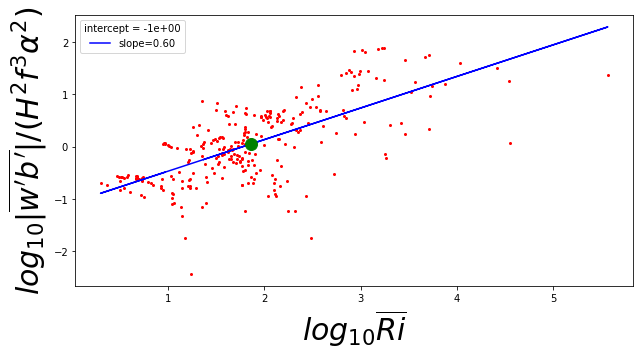

In [66]:

fig, ax = plt.subplots(figsize = (10, 5))
plt.plot(logx, logy , 'ro', markersize=2)

powerlaw = lambda x, amp, index: amp * (x**index)
res = stats.linregress(logx, logy)
plt.plot(logx, res.intercept + res.slope*logx, 'b', label=f'slope={res.slope:.2f}')

# x1 = np.linspace(-1,6,100)
# y1 = -0.5*x1 + 1
# plt.plot(x1,y1, label='slope ALS, NLS: -0.5', color='black')
#plt.xlim(0,6)
#plt.ylim(-12,-6)
ax.set_xlabel(r'$log_{10} \overline{Ri}$', fontsize=30)
ax.set_ylabel(r'$log_{10} |\overline{w^{\prime} b^{\prime}}|/(H^2 f^3 \alpha^2) $', fontsize=30)

plt.plot(logx_mean, logy_mean,'o', markersize=12, color='g')

plt.legend(title=f'intercept = {res.intercept:.1}')

#plt.savefig(f'../images/eval_ri/wb_ri_vert_mean_scaled_alpha_{calcname}.png', dpi=150, format='png', bbox_inches='tight')
#plt.savefig(f'../images/eval_ri/corellation_front.png', dpi=150, format='png', bbox_inches='tight')
#plt.savefig(f'../images/eval_ri/corellation_front_week.png', dpi=150, format='png', bbox_inches='tight')


res

# Vertical profiles

In [346]:
wb = data_wb_prime_mean.sel(lat=slice(32.5,33.5)).sel(lon=-61.25, method='nearest')
n2 = data_n2_mean.sel(lat=slice(32.5,33.5)).sel(lon=-61.25, method='nearest')
m2 = data_M2_mean.sel(lat=slice(32.5,33.5)).sel(lon=-61.25, method='nearest')
ri = ri_mean_select.sel(lat=slice(32.5,33.5)).sel(lon=-61.25, method='nearest')


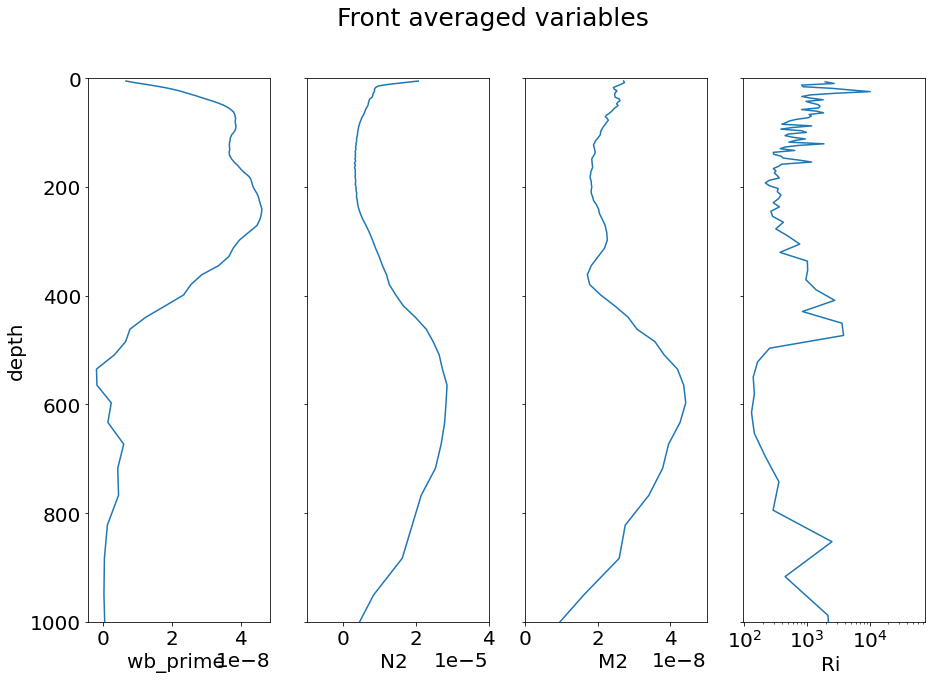

In [363]:
fig, ax = plt.subplots(1,4, figsize=(15,10), sharey=True, squeeze=True)
fig.suptitle('Front averaged variables', fontsize=25)

ax[0].plot(wb.mean(axis=1).data, depthi)
ax[0].set_ylim(1000,0)
ax[0].set_xlabel('wb_prime ', fontsize=20)
ax[0].set_ylabel('depth', fontsize=20)

ax[1].plot(n2.mean(axis=1).data, depthi)
ax[1].set_ylim(1000,0)
ax[1].set_xlim(-1e-5,4e-5)
ax[1].set_xlabel('N2 ', fontsize=20)

ax[2].plot(m2.mean(axis=1).data, depthi)
ax[2].set_ylim(1000,0)
ax[2].set_xlim(0,0.5e-7)
ax[2].set_xlabel('M2 ', fontsize=20)

ax[3].semilogx(ri.mean(axis=1).data, depthc)
ax[3].set_ylim(1000,0)
#ax[2].set_xlim(-1e-5,4e-5)
ax[3].set_xlabel('Ri ', fontsize=20)

plt.savefig(f'../images/eval_ri/front_averaged_var.png', dpi=150, format='png', bbox_inches='tight')
